In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

In [54]:
#Data collection
data = yf.download(tickers='JNJ', start='2015-1-1', end='2023-12-31')
data = data['Close']
data

[*********************100%***********************]  1 of 1 completed


Ticker,JNJ
Date,
2015-01-02,104.519997
2015-01-05,103.790001
2015-01-06,103.279999
2015-01-07,105.559998
2015-01-08,106.389999
...,...
2023-12-22,155.460007
2023-12-26,156.139999
2023-12-27,156.350006


In [55]:
data.tail(20)

Ticker,JNJ
Date,
2023-12-01,158.380005
2023-12-04,158.880005
2023-12-05,158.550003
2023-12-06,156.619995
2023-12-07,155.399994
2023-12-08,154.419998
2023-12-11,155.059998
2023-12-12,155.070007
2023-12-13,155.789993


In [ ]:
# Data collection for future accuracy checking
actual_df = yf.download(tickers='JNJ',start='2023-12-14',end='2024-2-13')
actual_df = actual_df['Close']
actual_df.columns = ['Close']
actual_df.shape

[*********************100%***********************]  1 of 1 completed


(40, 1)

In [57]:
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length, 0])
        y.append(data[i + seq_length, 0])
    return np.array(x), np.array(y)

sequence_length = 50
x, y = create_sequences(data_scaled, sequence_length)

In [58]:
# Reshape input to [samples, time steps, features]
x = np.reshape(x, (x.shape[0], x.shape[1], 1))

In [59]:
# Split into training and testing sets
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [60]:
# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)),
    LSTM(50, return_sequences=False),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\Prerana Walvekar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [61]:
# Training model
model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 0.0517 - val_loss: 0.0028
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0014 - val_loss: 0.0021
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0011 - val_loss: 0.0024
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 11/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 9.2021e-04 - val_loss: 0.0010
Epoch 12/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss:

In [62]:
# Predict using test set
y_pred_scaled = model.predict(x_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


In [63]:
# Inverse transform the scaled data
y_test = scaler.inverse_transform([y_test]).flatten()
y_pred = scaler.inverse_transform(y_pred_scaled).flatten()

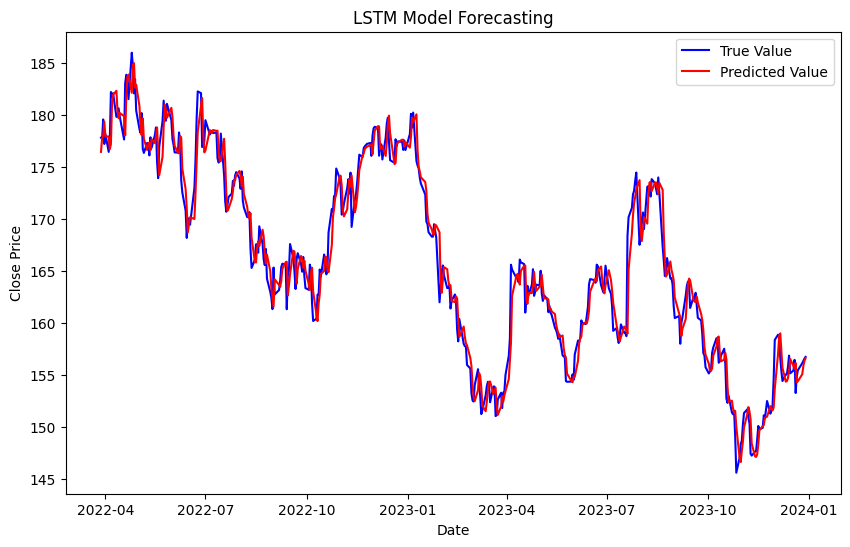

In [64]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(data.index[-len(y_test):], y_test, label='True Value', color='blue')
plt.plot(data.index[-len(y_test):], y_pred, label='Predicted Value', color='red')
plt.legend()
plt.title('LSTM Model Forecasting')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

**Prediction Accuracy**

In [65]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mean_actual = np.mean(y_test)

# Accuracy Calculation
accuracy = 100 - (rmse / mean_actual * 100)

print(f"RMSE: {rmse:.2f}")
print(f"Accuracy: {accuracy:.2f}%")

RMSE: 1.85
Accuracy: 98.89%


**Forecasting**

In [66]:
# Forecast future steps
def forecast_future(model, recent_data, n_steps):
    predictions = []
    current_input = recent_data.copy()

    for _ in range(n_steps):
        prediction = model.predict(current_input[np.newaxis, :, np.newaxis])
        predictions.append(prediction[0, 0])
        current_input = np.roll(current_input, -1)
        current_input[-1] = prediction

    return np.array(predictions)

# Forecast next 30 days
recent_data = data_scaled[-sequence_length:].flatten()
future_steps = 40
future_forecast_scaled = forecast_future(model, recent_data, future_steps)
future_forecast = scaler.inverse_transform(future_forecast_scaled.reshape(-1, 1)).flatten()

print("Future Forecast (Next 30 Days):", future_forecast)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

C:\Users\Prerana Walvekar\AppData\Local\Temp\ipykernel_20568\3973470603.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_input[-1] = prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━

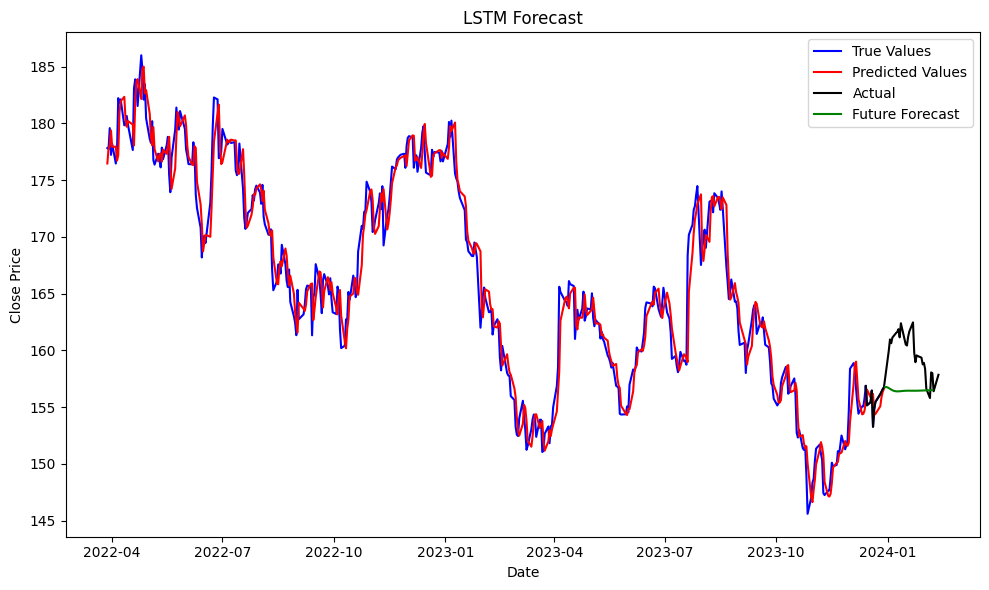

In [67]:
plt.figure(figsize=(10, 6))

# Plot historical true values
plt.plot(data.index[-len(y_test):], y_test, label="True Values", color='blue')

# Plot historical predictions
plt.plot(data.index[-len(y_test):], y_pred, label="Predicted Values", color='red')

# Plot actual values
plt.plot(actual_df['Close'],label='Actual',color='Black')

# Plot future forecast
future_dates = [data.index[-1] + pd.Timedelta(days=i) for i in range(1, future_steps + 1)]
plt.plot(future_dates, future_forecast, label="Future Forecast", color='green')

# Show plot
plt.title("LSTM Forecast")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.tight_layout()
plt.show()

**Prediction**

In [68]:
future_actual_prices = actual_df['Close'].values 
future_actual_prices.shape,future_forecast.shape

((40,), (40,))

In [69]:
# Calculate Mean Absolute Percentage Error (MAPE)
mape_forecast = np.mean(np.abs((future_actual_prices - future_forecast) / future_actual_prices)) * 100

# Calculate accuracy
accuracy_forecast = 100 - mape_forecast

# Print results
print(f"Forecasting Accuracy: {accuracy_forecast:.2f}%")
print(f"MAPE for Forecasting: {mape_forecast:.2f}%")


Forecasting Accuracy: 98.36%
MAPE for Forecasting: 1.64%
